# Introdução à Séries Temporais

## Tiago de Paula Dantas da Silva

### O que é uma Série Temporal?

Uma Série Temporal é uma sequência de observações de um dado em um intervalo de tempo. Esse dado costuma ter seu valor alterado ao passar do tempo, sendo assim, o objetivo de estudo de Séries Temporais é de identificar padrões nos comportamentos passados desse dado, para que seja possível prever como ele irá agir no futuro.

Exemplos de Séries Temporais são: preços de ações, temperatura de uma cidade, número de vendas em uma loja, número de assinaturas de um produto e etc.

<p style="text-align: center;">
    <img src="Imagens/ts-pp-seasonality.jpg" style="height:400px; width:800px; display: block; margin: 0 auto">
    <a href="https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/">Créditos</a>
</p>

### Componentes de uma Série Temporal

Uma **série temporal** possui informações que a compoem, são elas:
- **Nível Base**: Valor médio da série, conforme os outros componentes são acrescentrados ao "Nível Base", a série é construída! 
- **Tendência**: é o comportamento da série a longo prazo, isso indica se ela tem uma tendência de crescimento ou decrescimento.
- **Sazonalidade**: padrões períodicos que ocorrem na série temporal.
- **Resíduo/Ruído**: variações na série que não podem ser previstas, não são influênciadas pela têndencia e sazonalidade, teoricamente, o ruído deve ser aleatório.

### Decomposição de uma Série Temporal

Toda **série temporal** é uma combinação dos quatro elementos citados acima, e existem duas formas de agregarmos esses elementos, utilizando soma ou multiplicação.

#### Modelo Aditivo

$Série = NívelBase + Tendência + Sazonalidade + Resíduo$

Um modelo **aditivo** indica **linearidade**, sendo assim, a tendência seria melhor representada por uma linha reta, e a sazonalidade teria uma mesma frequência(largura dos padrões) e uma mesma amplitude(altura dos padrões).

#### Modelo Multiplicativo

$Série = NívelBase * Tendência * Sazonalidade * Resíduo$

Um modelo **multiplicativo** indica **não-linearidade**, como um modelo quadrático ou exponencial, sendo assim, a tendência seria melhor representada por uma linha curvada, e a sazonalidade possui um crescimento ou decrescimento na frequência e/ou na amplitude.

### Como isso funciona na prática?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

<h4><a href="https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting?select=Alcohol_Sales.csv">Venda de bebidas alcólicas</a> </h4>

In [2]:
sales = pd.read_csv('Datasets/Alcohol_Sales.csv')

In [3]:
sales.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            325 non-null    object
 1   S4248SM144NCEN  325 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [5]:
sales.rename(columns={'S4248SM144NCEN':'Sales'}, inplace=True)

In [6]:
sales['DATE'] = pd.to_datetime(sales['DATE'])
sales.sort_values(by=['DATE'], inplace=True)

Interessante método para saber a diferença entre datas consecutivas!

In [7]:
sales['diff'] = sales['DATE'].diff()

In [8]:
sales['diff'].value_counts()

31 days    189
30 days    108
28 days     20
29 days      7
Name: diff, dtype: int64

In [9]:
sales.drop('diff', axis=1, inplace=True)

In [10]:
sales.set_index('DATE', inplace=True)
sales.index.freq = 'MS'

In [11]:
sales.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [12]:
sales.tail()

,Sales
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


<AxesSubplot: xlabel='DATE'>

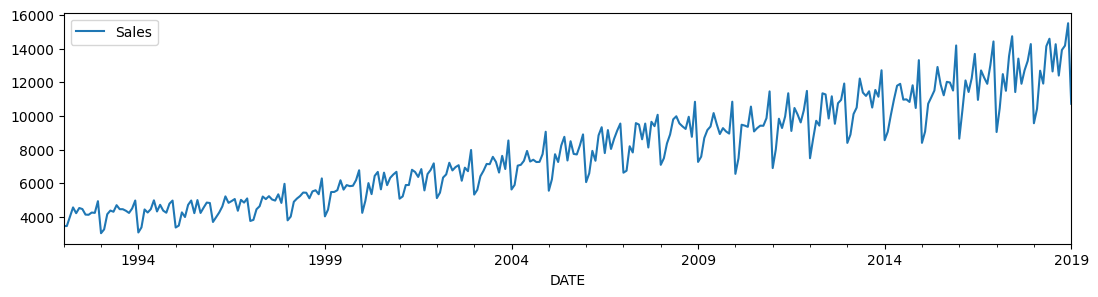

In [13]:
sales.plot(figsize=(13, 3))

#### Decomposição na prática

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
result = seasonal_decompose(sales, model='additive')

Uma métrica para saber qual o modelo(**aditivo** ou **multiplicativo**) que a nossa série temporal se adequa, é checando o résiduo, aquele que se mostrar mais aleatório, indica que a série se adapta melhor aquele modelo!

<AxesSubplot: xlabel='DATE'>

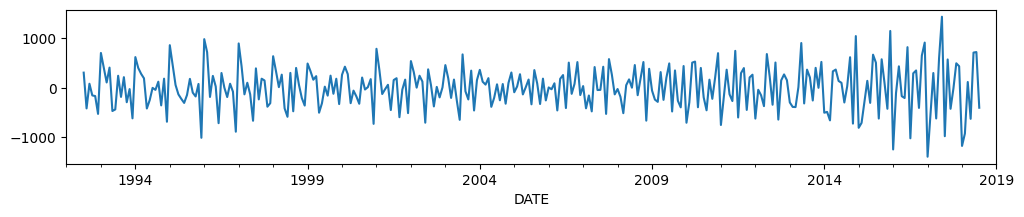

In [16]:
result.resid.plot(figsize=(12, 2))

In [17]:
result = seasonal_decompose(sales, model='multiplicative')

<AxesSubplot: xlabel='DATE'>

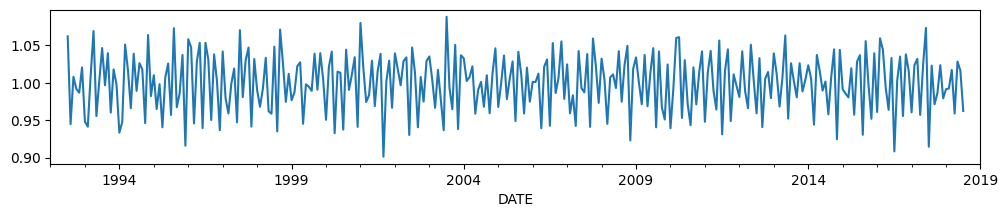

In [18]:
result.resid.plot(figsize=(12, 2))

Analisando os resíduos acima, podemos perceber que ambos não apresentaram muito padrões aparentes, porém acredito que o **multiplicativo** se mostrou um pouco mais aleatório, então irei escolh-lo para a decomposição.

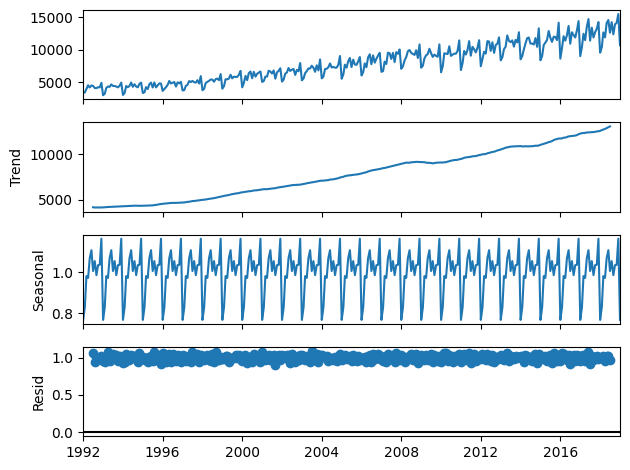

In [19]:
result = seasonal_decompose(sales, model='multiplicative')
fig = result.plot()
plt.show()

<AxesSubplot: xlabel='DATE'>

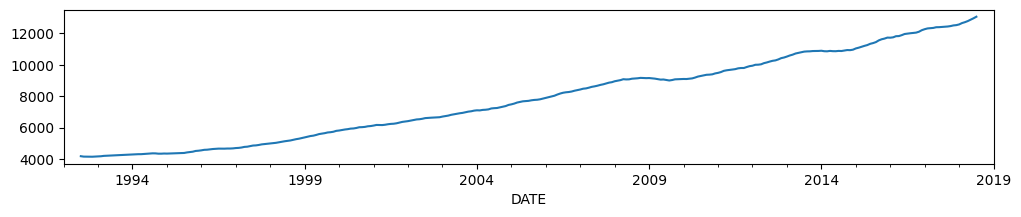

In [20]:
result.trend.plot(figsize=(12, 2))

<AxesSubplot: xlabel='DATE'>

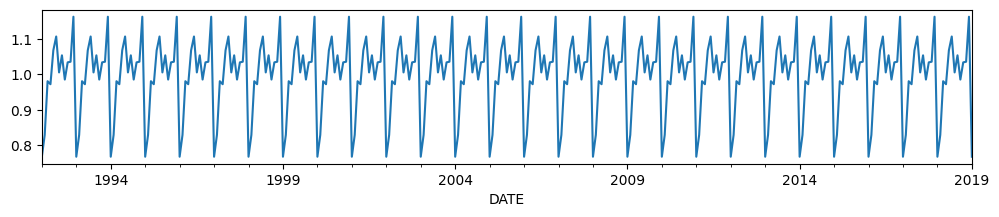

In [21]:
result.seasonal.plot(figsize=(12, 2))

<AxesSubplot: xlabel='DATE'>

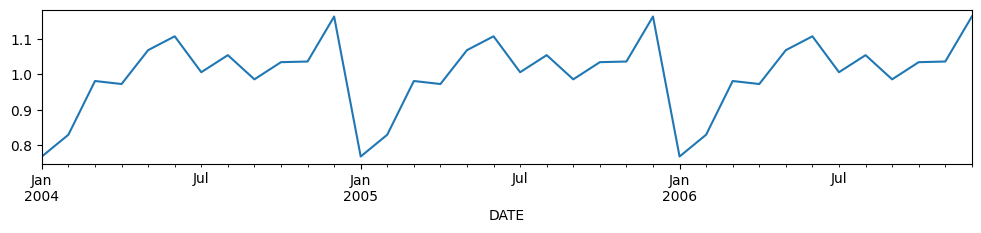

In [22]:
result.seasonal['2004':'2006'].plot(figsize=(12, 2))

<AxesSubplot: xlabel='DATE'>

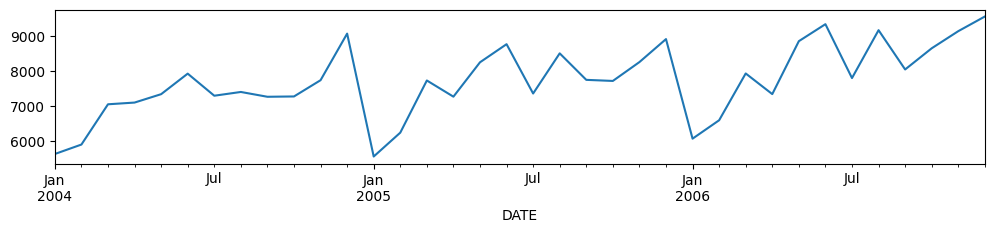

In [23]:
result.observed['2004':'2006'].plot(figsize=(12, 2))

In [24]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [25]:
sales['year'] = sales.index.year
sales['month'] = sales.index.month

<AxesSubplot: title={'center': 'Seasonal Plot (year/month)'}, xlabel='month', ylabel='Sales'>

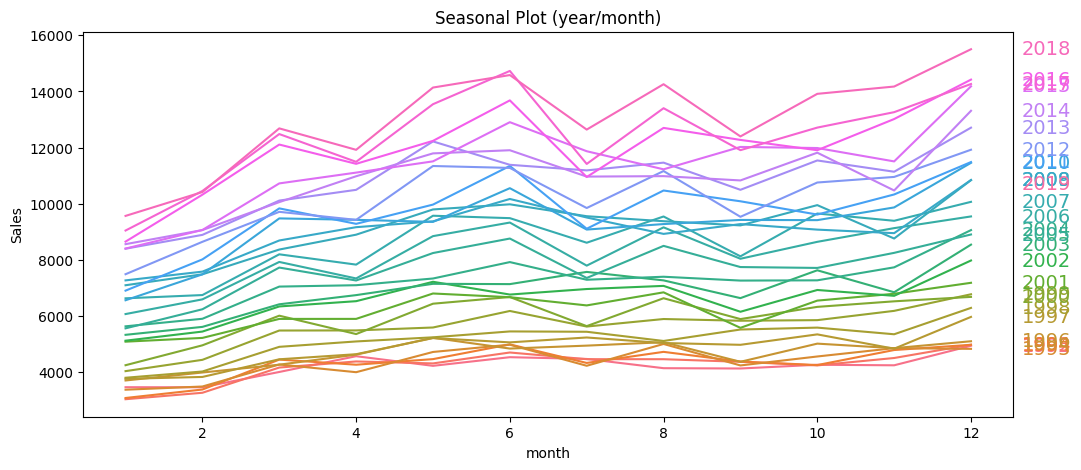

In [26]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12, 5))
seasonal_plot(sales, y='Sales', period='year', freq='month', ax=ax0)

In [27]:
sales.drop(['year', 'month'], axis=1, inplace=True)

Agora temos algumas informações importantes sobre os dados:
- Obdece a uma têndencia linear, logo precisamos de uma variável para ajudar o modelo a construir a reta de crescimento
- Percebemos que temos uma sazonalidade nos meses, então seria importante termos uma variável para identificar os meses

In [28]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [29]:
dp = DeterministicProcess(
    index=sales.index,         
    order=1,                # trend (order 1 means linear)
    seasonal=True,          # monthy seasonality (indicators)
    drop=True               # drop terms to avoid collinearity
)

X = dp.in_sample()
y = sales['Sales']

In [30]:
X.head()

,trend,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
DATE,,,,,,,,,,,,,
1992-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-02-01,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-03-01,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-04-01,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992-05-01,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Uma outra informação que pode nos ajudar são dados sobre vendas anteriores, ou seja, para eu prever a venda desse mês eu poderia utilizar os valores de meses antes de mim, isso se chama *"lag feature"*. 

Então, para calcular as vendas do mês atual, eu posso usar a venda do mês anterior, ou dos dois meses anteriores, ou dos três, e pos ai vai...

Essa informação de "atraso" é muito importante por exemplo, quando temos **ciclos** na série temporal!

<p style="text-align: center;">
    <img src="Imagens/cycles.png" style="height:500px; width:800px; display: block; margin: 0 auto">
    <a href="https://www.kaggle.com/code/ryanholbrook/time-series-as-features">Créditos</a>
</p>

Cabe afirmar que **ciclos** são diferentes de **sazonalidade**, a segunda indica um padrão períodico, ou seja de semana em semana, mês e mês e etc. Já os ciclos são comportamentos não-períodicos, de crescimento seguido de um descrescimento, eles não dependem do tempo, apenas de valores passados recentes. 

Uma boa forma de saber se a série temporal possui um **ciclo** ou se a utilização da *"lag feature"* seria uma boa informação para o modelo é analisando gráficos de **autocorrelação** e **autocorrelação parcial**.

In [31]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

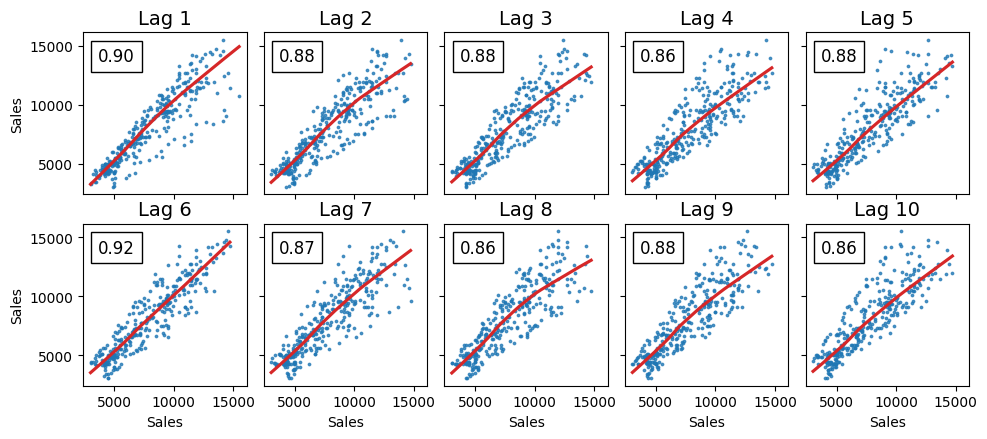

In [32]:
fig = plot_lags(y, lags=10, nrows=2)
plt.show()

No gráfico acima, é possível analisar o grau de **autocorrelação** que a série possui com os "atrasos", e também cabe afirmar que essas correlações possui um grau de linearidade bem alto.

É muito importante analisar a linearidade dos "lags", pois a **autocorrelação** é uma medida de dependência linear!

Então, utilizar "lags" que não possuem uma correlação linear pode não dar muito certo!

Outro ponto a ser comentado é que a **autocorrelação** da série com o lag $k$, é calculada como a correlação do lag $k$ contando com todos os outros lags menores do que $k$ e maiores que $0$.

Então com essa medida, pode ser que, apesar de um lag $k$ possuir uma alta correlação, na verdade grande parte dessa correlação esta vindo de um lag $i$($i<k$ e $i>0$) antes dele, e na verdade o lag $k$ nem influência tanto a série. 

Uma forma de analisarmos a influência de um lag $k$, sozinha, sem depender dos outros que vem antes dele, é através do gráfico de **autocorrelação parcial**.

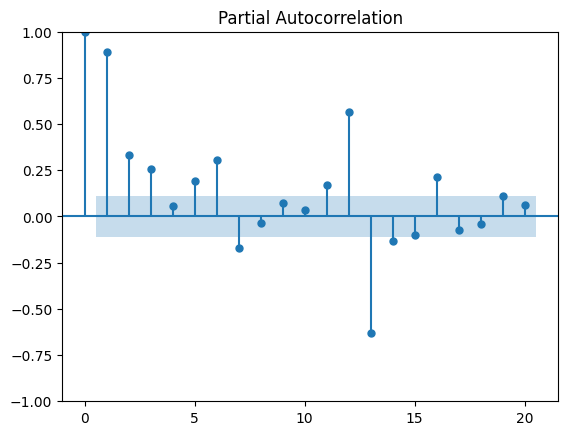

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(y, lags=20)
plt.show()

Nele, é mostrado a correlação de cada lag separado, onde o retângulo azul indica que aquele lag não têm uma influência significativa na série.

Atráves do gráfico de **autocorrelação** é possível perceber que a influência acumulada até o lag 6 é a maior de todas e bem linear, e além disso pelo gráfico de **autocorrelação parcial** todos os lags até o 6, menos o 4, possuem uma relevância significativa, sendo assim irei utilizar $6$ lags para melhorar o nosso modelo!

In [34]:
def lagged(X, y, lags):
    for i in range(lags):
        X['lag'+str(i+1)] = y.shift(i+1)

    return X

In [35]:
lags = 6

X = lagged(X, y, lags)

In [36]:
X.head(7)

,trend,"s(1,12)","s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)",lag1,lag2,lag3,lag4,lag5,lag6
DATE,,,,,,,,,,,,,,,,,,,
1992-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3459.0,NaN,NaN,NaN,NaN,NaN
1992-03-01,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3458.0,3459.0,NaN,NaN,NaN,NaN
1992-04-01,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4002.0,3458.0,3459.0,NaN,NaN,NaN
1992-05-01,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4564.0,4002.0,3458.0,3459.0,NaN,NaN
1992-06-01,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4221.0,4564.0,4002.0,3458.0,3459.0,NaN
1992-07-01,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4529.0,4221.0,4564.0,4002.0,3458.0,3459.0


In [37]:
X.dropna(inplace=True)

In [38]:
y.drop(y[:lags].index, axis=0, inplace=True)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

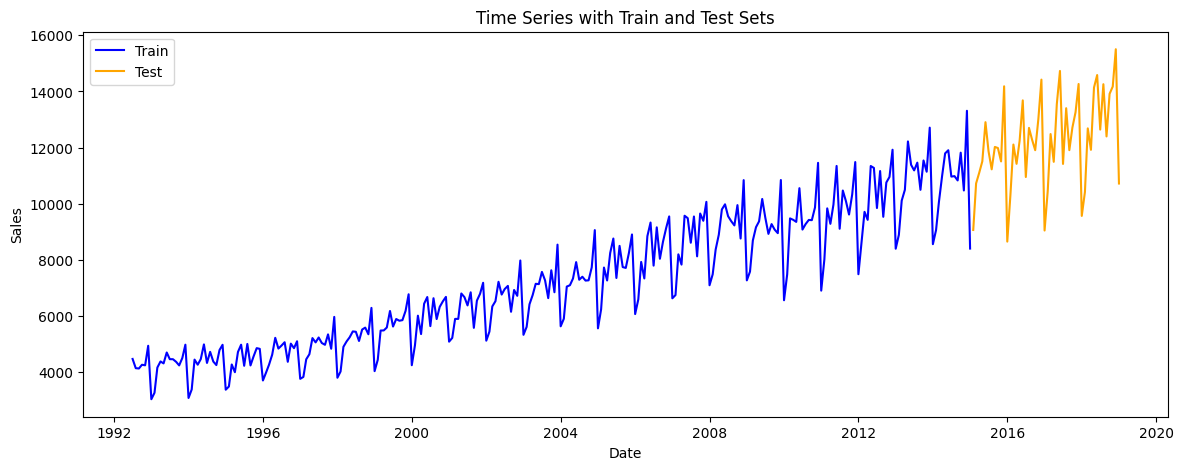

In [40]:
plt.figure(figsize=(14, 5))

plt.plot(X_train.index, y_train, color='blue', label='Train')

plt.plot(X_test.index, y_test, color='orange', label='Test')

plt.title('Time Series with Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.legend()
plt.show()

In [41]:
def get_metrics(test, pred):
    mae = metrics.mean_absolute_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = np.sqrt(mse)
    mape = metrics.mean_absolute_percentage_error(test, pred)

    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

In [42]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

MAE: 564.9828971025645
RMSE: 688.6173572476114
MAPE: 0.046665675703833114


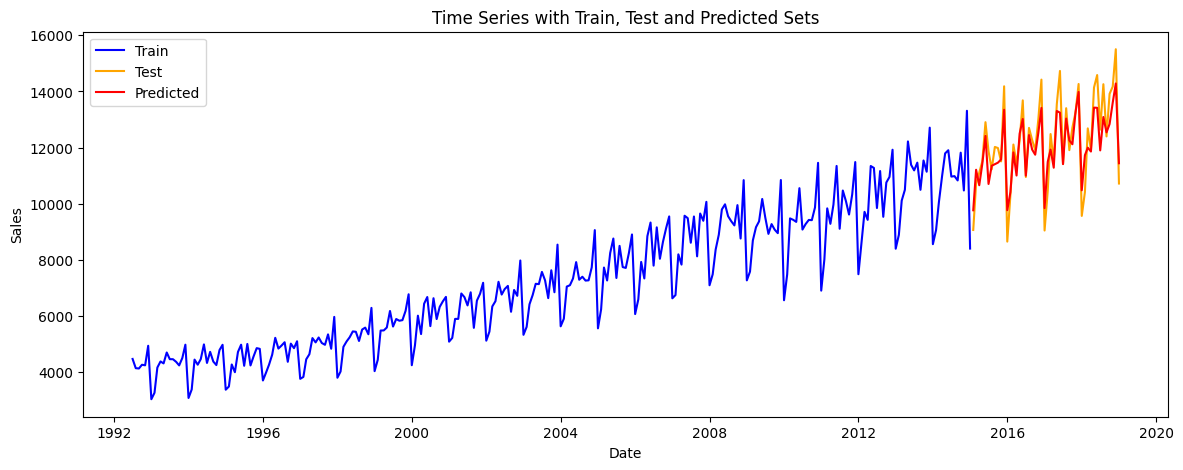

In [43]:
plt.figure(figsize=(14, 5))

plt.plot(X_train.index, y_train, color='blue', label='Train')

plt.plot(X_test.index, y_test, color='orange', label='Test')

plt.plot(X_test.index, y_pred, color='red', label='Predicted')

plt.title('Time Series with Train, Test and Predicted Sets')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.legend()
plt.show()

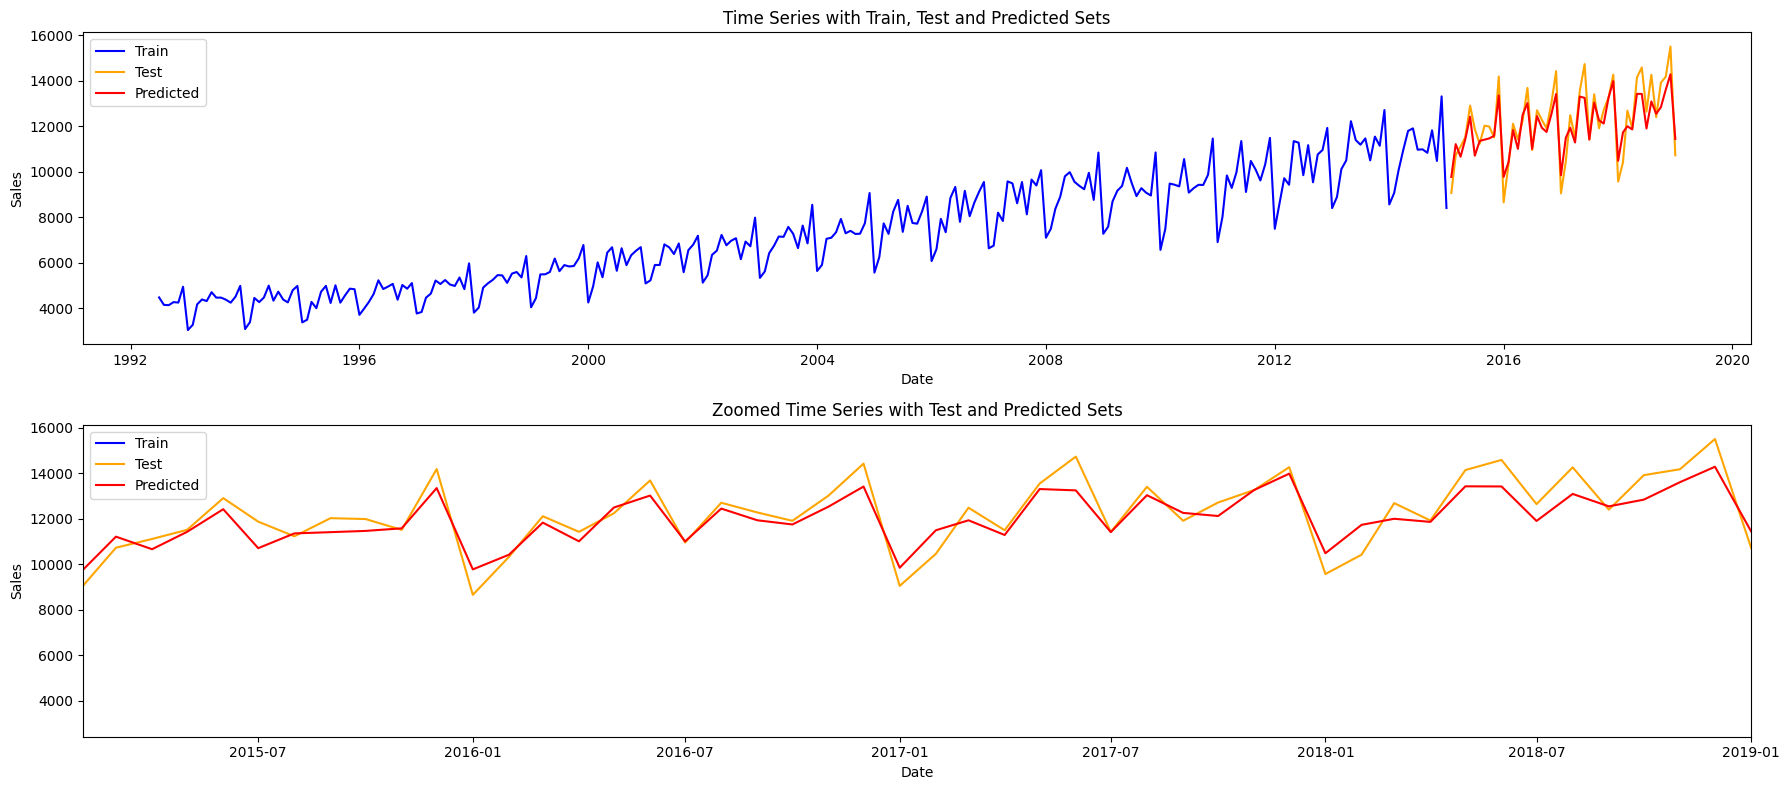

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# Primeiro plot
axes[0].plot(X_train.index, y_train, label='Train', color='blue')
axes[0].plot(X_test.index, y_test, label='Test', color='orange')
axes[0].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[0].set_title('Time Series with Train, Test and Predicted Sets')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')

axes[0].legend()

# Segundo plot
axes[1].plot(X_train.index, y_train, label='Train', color='blue')
axes[1].plot(X_test.index, y_test, label='Test', color='orange')
axes[1].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[1].set_xlim([X_test.index.min(), X_test.index.max()])

axes[1].set_title('Zoomed Time Series with Test and Predicted Sets')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')

axes[1].legend()

plt.tight_layout()
plt.show()

In [45]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

MAE: 1698.4103597005208
RMSE: 1996.9477775386822
MAPE: 0.13190035653365437


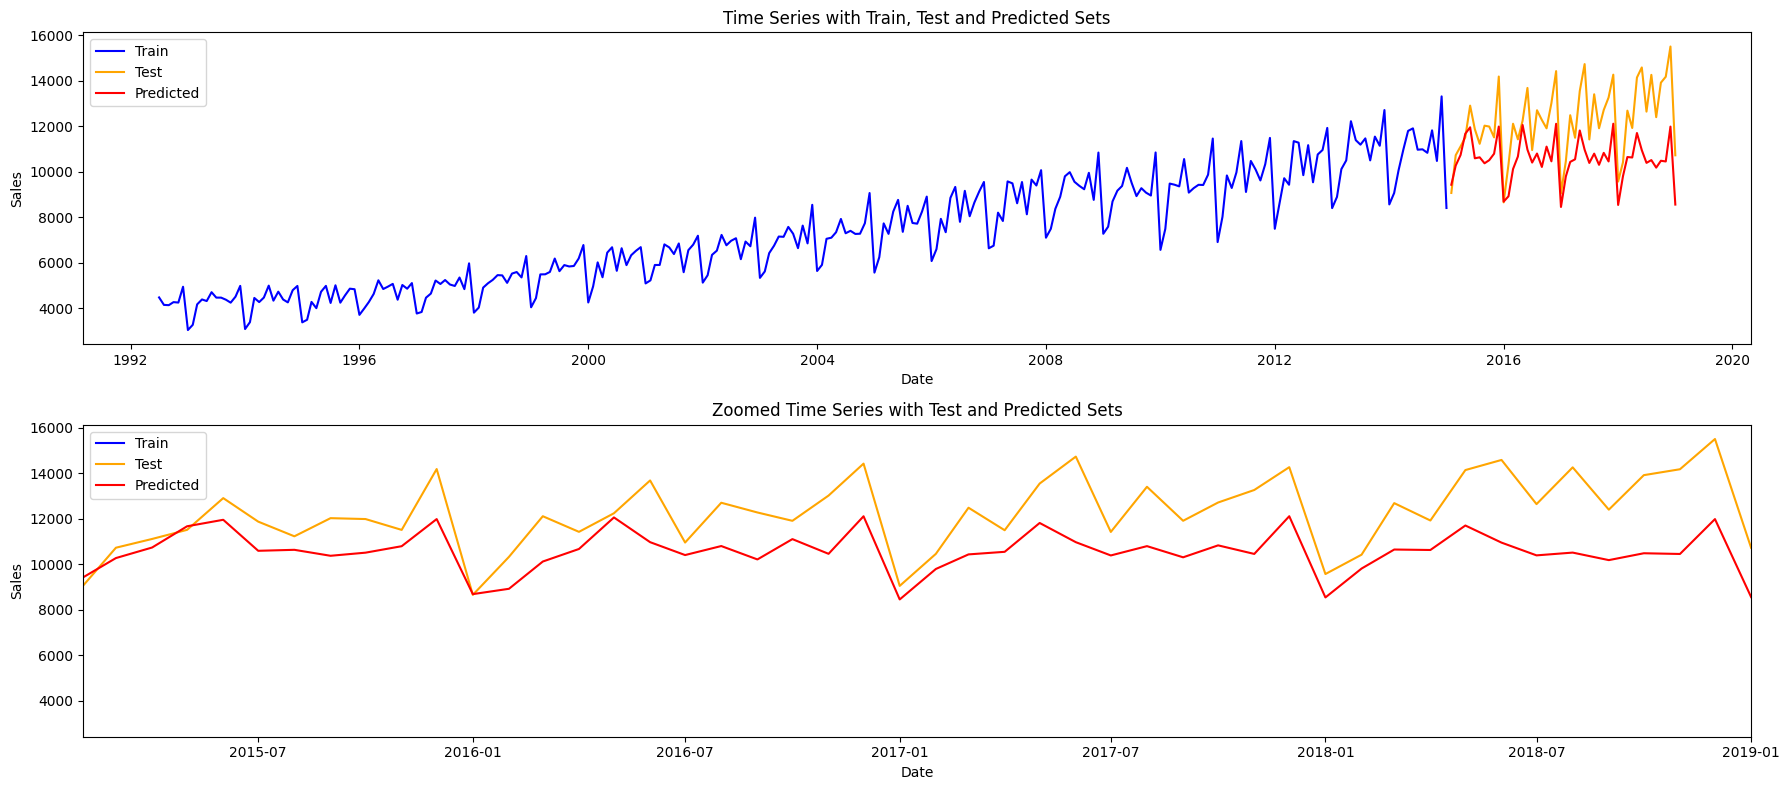

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# Primeiro plot
axes[0].plot(X_train.index, y_train, label='Train', color='blue')
axes[0].plot(X_test.index, y_test, label='Test', color='orange')
axes[0].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[0].set_title('Time Series with Train, Test and Predicted Sets')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')

axes[0].legend()

# Segundo plot
axes[1].plot(X_train.index, y_train, label='Train', color='blue')
axes[1].plot(X_test.index, y_test, label='Test', color='orange')
axes[1].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[1].set_xlim([X_test.index.min(), X_test.index.max()])

axes[1].set_title('Zoomed Time Series with Test and Predicted Sets')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')

axes[1].legend()

plt.tight_layout()
plt.show()

In [47]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

MAE: 1341.2789583333333
RMSE: 1742.712480757966
MAPE: 0.10188408478059165


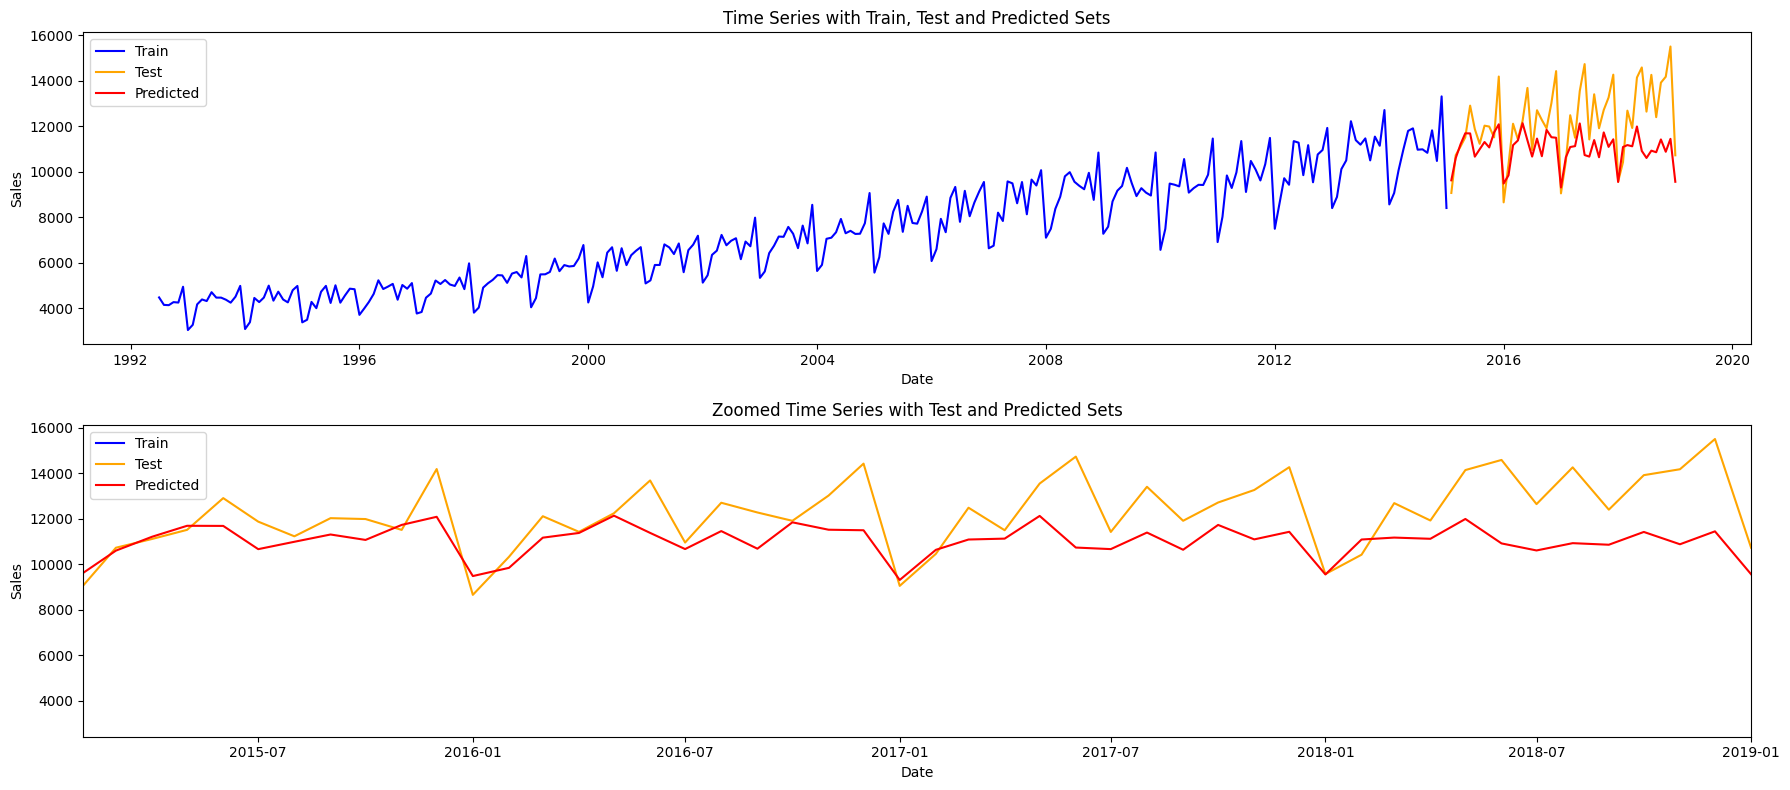

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# Primeiro plot
axes[0].plot(X_train.index, y_train, label='Train', color='blue')
axes[0].plot(X_test.index, y_test, label='Test', color='orange')
axes[0].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[0].set_title('Time Series with Train, Test and Predicted Sets')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')

axes[0].legend()

# Segundo plot
axes[1].plot(X_train.index, y_train, label='Train', color='blue')
axes[1].plot(X_test.index, y_test, label='Test', color='orange')
axes[1].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[1].set_xlim([X_test.index.min(), X_test.index.max()])

axes[1].set_title('Zoomed Time Series with Test and Predicted Sets')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')

axes[1].legend()

plt.tight_layout()
plt.show()

É possível perceber que o XGBoost e a Random Forest não obtiveram resultados muito interessantes, devido a tendência linear da série, porém conseguimos resultados bem relevantes com a **Regressão Linear**!

<h4><a href="https://www.kaggle.com/code/ryanholbrook/time-series-as-features/data?select=tunnel.csv">Número de carros que passam no tunel</a> </h4>

In [49]:
cars = pd.read_csv('Datasets/tunnel.csv')
cars.head()

,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


In [50]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Day          747 non-null    object
 1   NumVehicles  747 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [51]:
cars['Day'] = pd.to_datetime(cars['Day'])
cars.sort_values(by=['Day'], inplace=True)

In [52]:
cars.set_index('Day', inplace=True)
cars.index.freq = 'D'

In [53]:
cars.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [54]:
cars.tail()

,NumVehicles
Day,
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165
2005-11-15,114296
2005-11-16,114690


<AxesSubplot: xlabel='Day'>

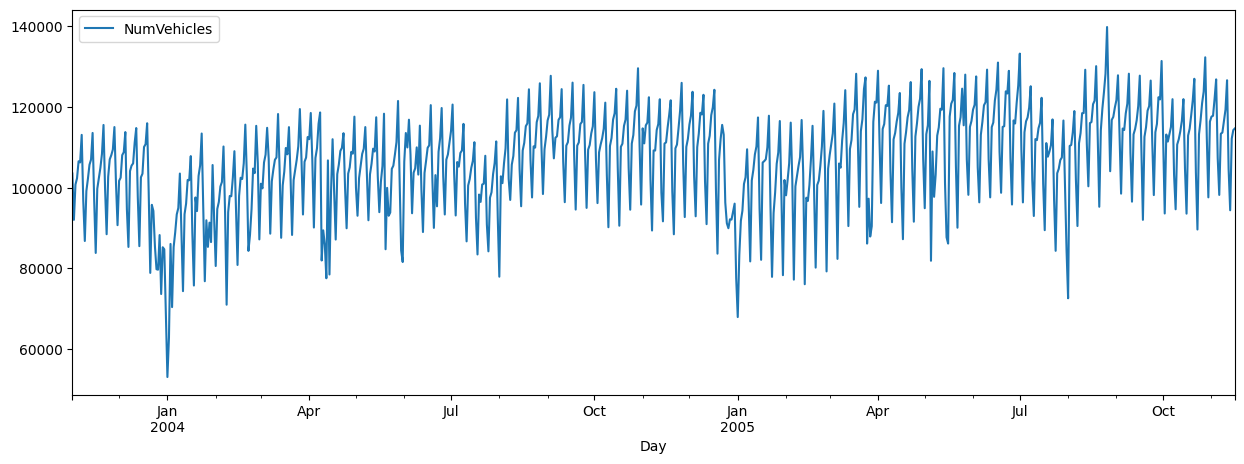

In [55]:
cars.plot(figsize=(15, 5))

In [56]:
result = seasonal_decompose(cars, model='additive')

<AxesSubplot: xlabel='Day'>

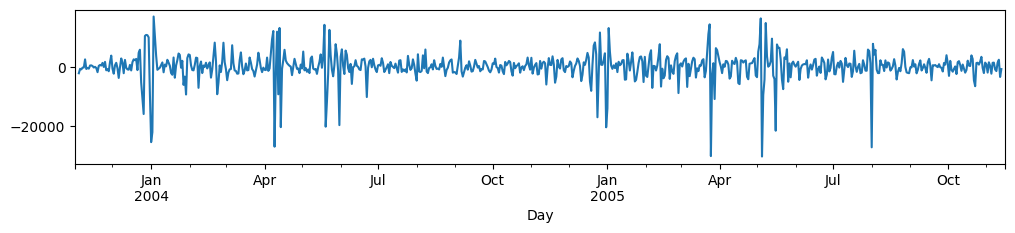

In [57]:
result.resid.plot(figsize=(12, 2))

In [58]:
result = seasonal_decompose(cars, model='multiplicative')

<AxesSubplot: xlabel='Day'>

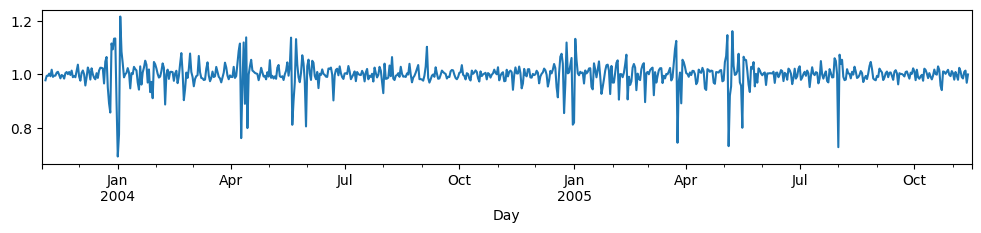

In [59]:
result.resid.plot(figsize=(12, 2))

Os dois resíduos parecem bem parecidos, porém irei escolher o modelo **aditivo** para nos analisarmos!

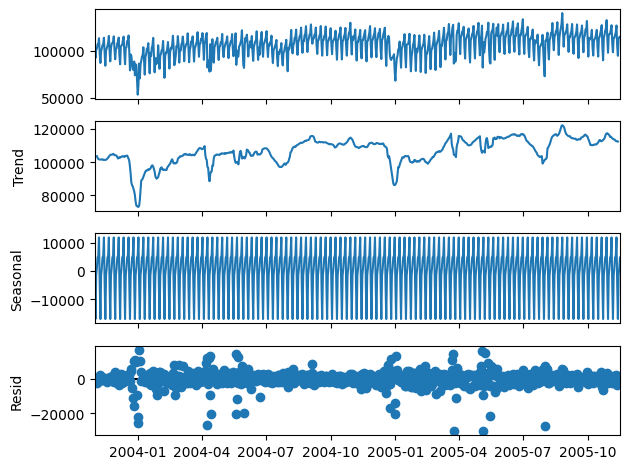

In [60]:
result = seasonal_decompose(cars, model='aditivo')
fig = result.plot()
plt.show()

<AxesSubplot: xlabel='Day'>

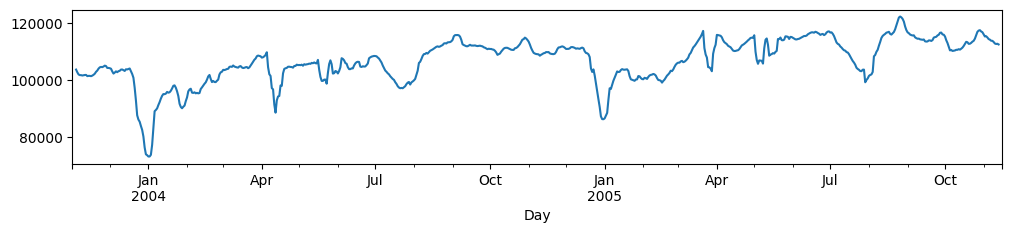

In [61]:
result.trend.plot(figsize=(12, 2))

Diferentemente da primeira série que analisamos, essa série não possui uma tendência de crescimento ou decrescimento bem estabelecida, sendo assim a nossa decomposição ficou bastante ruim!

<AxesSubplot: xlabel='Day'>

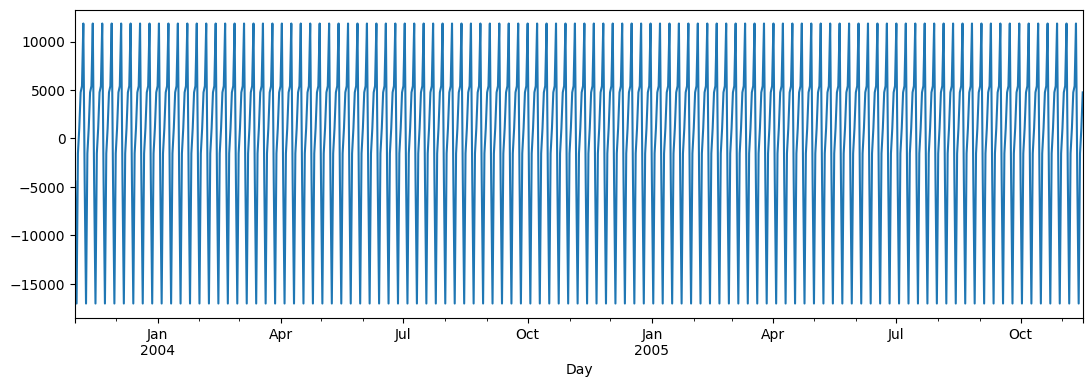

In [62]:
result.seasonal.plot(figsize=(13, 4))

De primeira vista, é possível identificar que a decomposição reconheceu uma sazonalidade entre os meses, possivelmente semanal!

<AxesSubplot: xlabel='Day'>

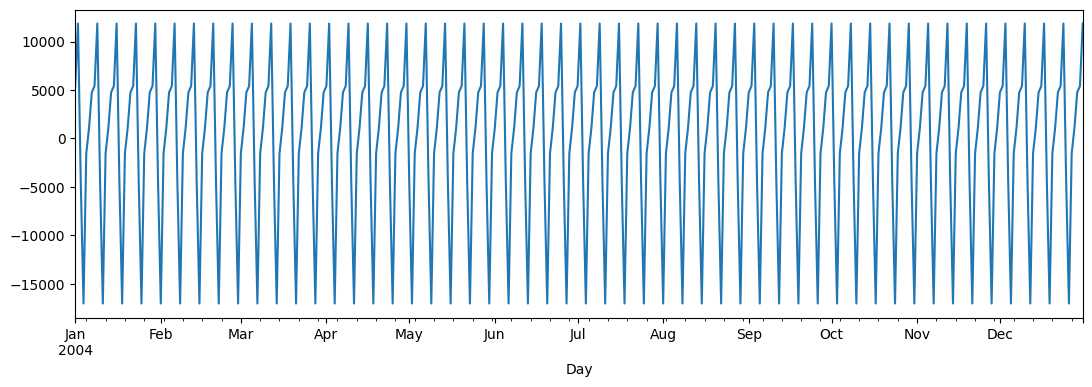

In [63]:
result.seasonal['2004'].plot(figsize=(13, 4))

<AxesSubplot: xlabel='Day'>

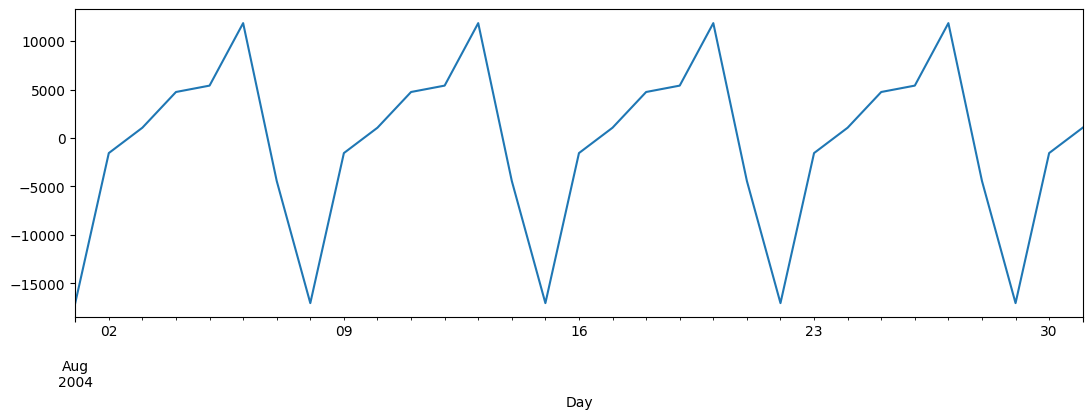

In [64]:
result.seasonal['2004-08'].plot(figsize=(13, 4))

Procurando mais afundo, realmente a decomposição achou uma sazonalidade semanal!

Vamos explorar um pouco mais essa série!

In [65]:
cars['week'] = cars.index.week
cars['day'] = cars.index.dayofweek
cars['year'] = cars.index.year
cars['dayofyear'] = cars.index.dayofyear

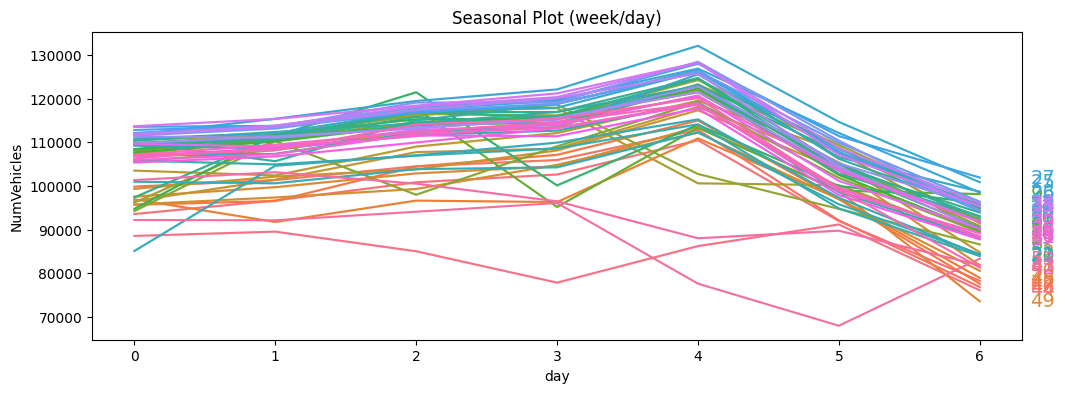

In [66]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12, 4))
seasonal_plot(cars, y="NumVehicles", period="week", freq="day", ax=ax0)
plt.show()

Podemos perceber que durante a semana, o número de veículos, tende a ter uma leve curva linear, até chegar na sexta, onde atinge o seu pico, e durante o fim de semana, no caso sábado e domingo, a uma diminuição no número de carros.

Outra sazonalidade que podemos investigar nessa série diária, é durante o ano!

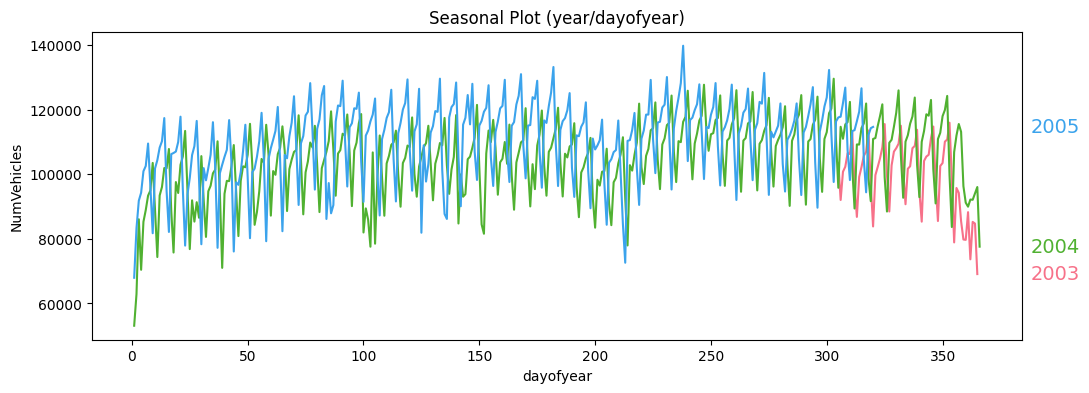

In [67]:
fig, (ax0) = plt.subplots(1, 1, figsize=(12, 4))
seasonal_plot(cars, y="NumVehicles", period="year", freq="dayofyear", ax=ax0)
plt.show()

Com esse gráfico podemos perceber uma mesma ocilação realizada pelos números dos anos de 2004 e 2005.

Seria interessanete conseguirmos extrair essa ocilação para o nosso modelo, e uma forma de realizarmos isso é utilizando **Fourier features**, que na verdade são apenas alguns senos e cossenos que somados se tornam a curva de sazonalidade.

Exemplo abaixo:

<p style="text-align: center;">
    <img src="Imagens/fourier.png" style="height:550px; width:800px; display: block; margin: 0 auto">
    <a href="https://www.kaggle.com/code/ryanholbrook/seasonality">Créditos</a>
</p>

Mas como sabemos quantos pares de senos e cossenos precisamos para gerarmos uma boa ocilação?

Uma maneira de realizar isso é utilizando um **periodograma**, um gráfico que indica o quão forte é uma determinada frequência para a série.

In [68]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

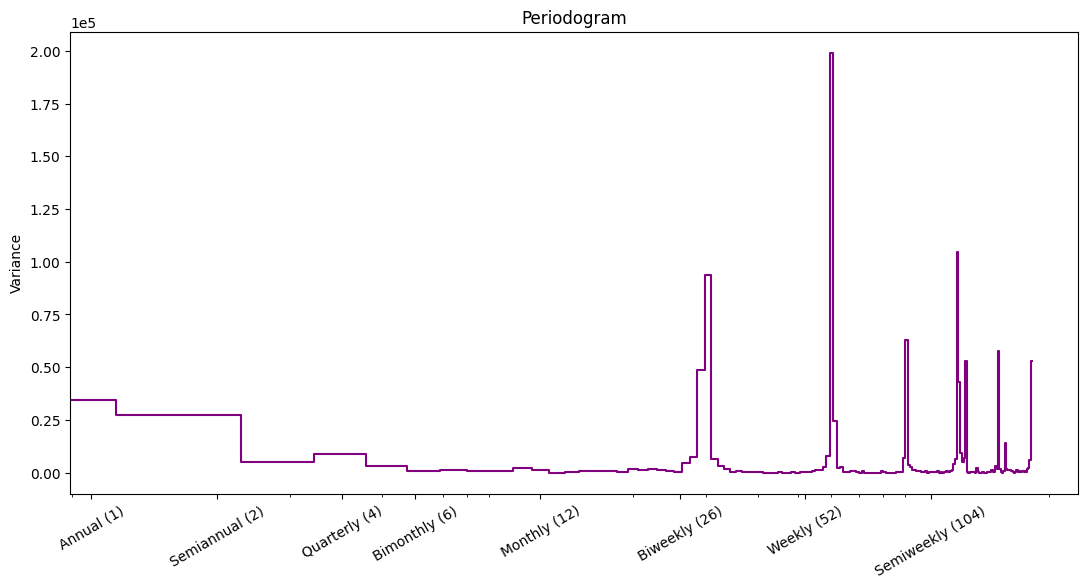

In [69]:
fig, (ax0) = plt.subplots(1, 1, figsize=(13, 6))
plot_periodogram(y, ax=ax0)
plt.show()

É possível perceber que com esse gráfico também conseguimos identificar a sazonalidade da semana, atráves do pico, que ocorre com essa frequência.

Eu particulamente acho a interpretação desse gráfico um pouco complicada para identificar o número ótimo de pares de senos e cossenos, porém a maneira que podemos fazer isso é observando o periodograma e vendo onde que ocorre o seu **decaimento**, isso seria indicado por uma frequência, na qual a partir dela, as frequências posteriores são irrelevantes e desproporcionais.

In [70]:
from statsmodels.tsa.deterministic import CalendarFourier

In [71]:
fourier = CalendarFourier(freq='A', order=10) # frequência anual e 10 pares

dp = DeterministicProcess(
    index=cars.index,
    order=0,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
)

X = dp.in_sample()
y = cars['NumVehicles']

In [72]:
X.head()

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,-0.863142,-0.504961,0.008607,-0.999963,0.871706,-0.490029,0.858764,0.512371,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,-0.880012,-0.474951,-0.043022,-0.999074,0.835925,-0.548843,0.899631,0.436651,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,-0.895839,-0.444378,-0.094537,-0.995521,0.796183,-0.605056,0.933837,0.357698,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,-0.910605,-0.413279,-0.145799,-0.989314,0.752667,-0.658402,0.961130,0.276097,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,-0.924291,-0.381689,-0.196673,-0.980469,0.705584,-0.708627,0.981306,0.192452,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


In [73]:
X["is_weekend"] = ((X.index.dayofweek == 5) | (X.index.dayofweek == 6)).astype(int)

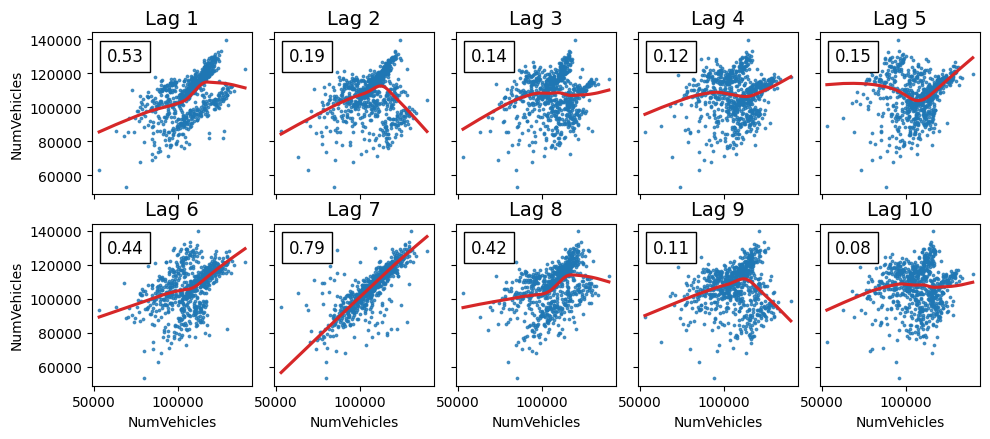

In [74]:
fig = plot_lags(y, lags=10, nrows=2)
plt.show()

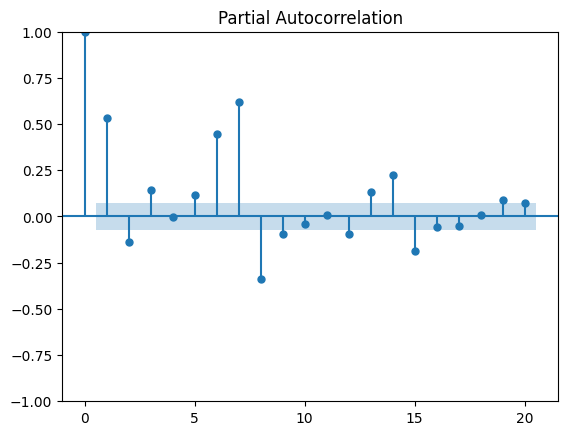

In [75]:
fig = plot_pacf(y, lags=20)
plt.show()

In [76]:
lags = 7

X = lagged(X, y, lags)

In [77]:
X.dropna(inplace=True)

In [78]:
y.drop(y[:lags].index, axis=0, inplace=True)

In [79]:
X.head()

,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)","sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)",is_weekend,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-11-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.801361,0.598181,-0.958718,-0.284359,-0.345612,-0.938377,0.545240,-0.838280,0.997917,-0.064508,0.648630,0.761104,-0.221922,0.975065,-0.914128,0.405426,-0.871706,-0.490029,-0.128748,-0.991677,1,113111.0,106284.0,106569.0,102352.0,100795.0,92051.0,103536.0
2003-11-09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790946,0.611886,-0.967938,-0.251190,-0.393590,-0.919286,0.486273,-0.873807,0.988678,-0.150055,0.723644,0.690173,-0.103102,0.994671,-0.849817,0.527078,-0.936881,-0.349647,-0.296713,-0.954967,1,96806.0,113111.0,106284.0,106569.0,102352.0,100795.0,92051.0
2003-11-10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.780296,0.625411,-0.976011,-0.217723,-0.440519,-0.897743,0.425000,-0.905193,0.972118,-0.234491,0.790946,0.611886,0.017213,0.999852,-0.769415,0.638749,-0.979614,-0.200891,-0.455907,-0.890028,0,86811.0,96806.0,113111.0,106284.0,106569.0,102352.0,100795.0
2003-11-11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.769415,0.638749,-0.982927,-0.183998,-0.486273,-0.873807,0.361714,-0.932289,0.948362,-0.317191,0.849817,0.527078,0.137279,0.990532,-0.674444,0.738326,-0.998880,-0.047321,-0.601624,-0.798779,0,99194.0,86811.0,96806.0,113111.0,106284.0,106569.0,102352.0
2003-11-12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.758306,0.651899,-0.988678,-0.150055,-0.530730,-0.847541,0.296713,-0.954967,0.917584,-0.397543,0.899631,0.436651,0.255353,0.966848,-0.566702,0.823923,-0.994218,0.107381,-0.729558,-0.683919,0,102253.0,99194.0,86811.0,96806.0,113111.0,106284.0,106569.0


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

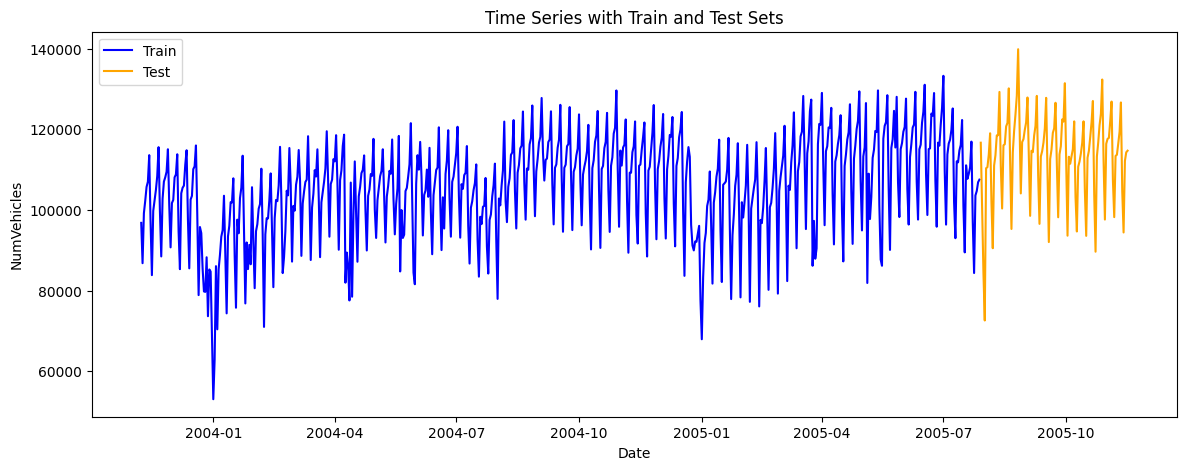

In [81]:
plt.figure(figsize=(14, 5))

plt.plot(X_train.index, y_train, color='blue', label='Train')

plt.plot(X_test.index, y_test, color='orange', label='Test')

plt.title('Time Series with Train and Test Sets')
plt.xlabel('Date')
plt.ylabel('NumVehicles')

plt.legend()
plt.show()

In [82]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

MAE: 2422.101878183545
RMSE: 4221.406584890117
MAPE: 0.022710850432710306


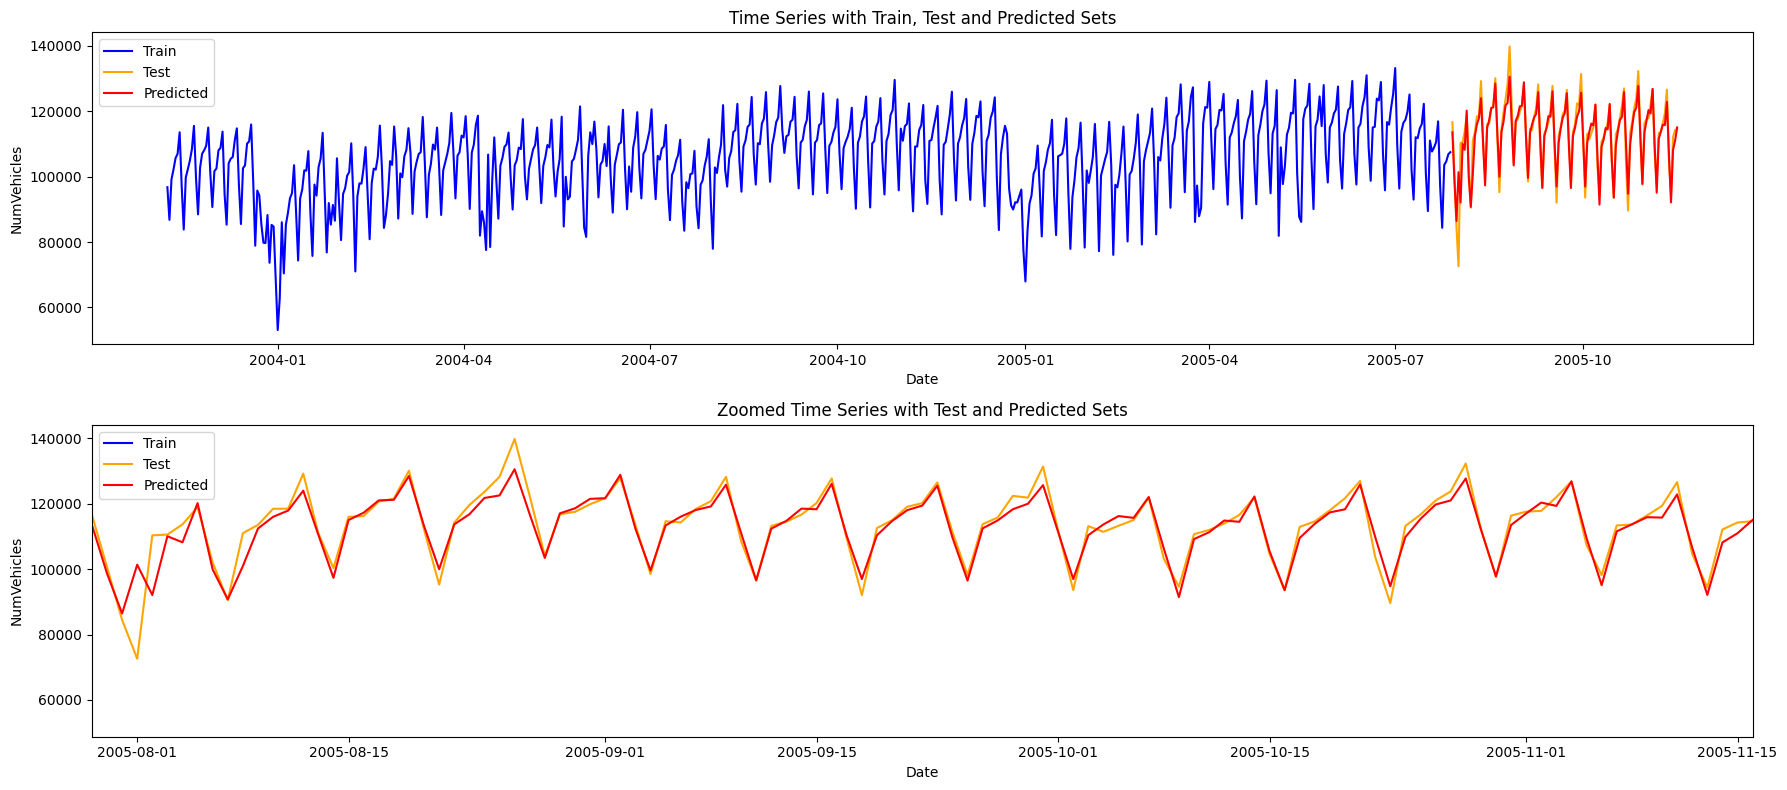

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# Primeiro plot
axes[0].plot(X_train.index, y_train, label='Train', color='blue')
axes[0].plot(X_test.index, y_test, label='Test', color='orange')
axes[0].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[0].set_title('Time Series with Train, Test and Predicted Sets')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('NumVehicles')

axes[0].legend()

# Segundo plot
axes[1].plot(X_train.index, y_train, label='Train', color='blue')
axes[1].plot(X_test.index, y_test, label='Test', color='orange')
axes[1].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[1].set_xlim([X_test.index.min(), X_test.index.max()])

axes[1].set_title('Zoomed Time Series with Test and Predicted Sets')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NumVehicles')

axes[1].legend()

plt.tight_layout()
plt.show()

In [84]:
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

MAE: 3229.257038288288
RMSE: 5938.917127086845
MAPE: 0.029389256674820948


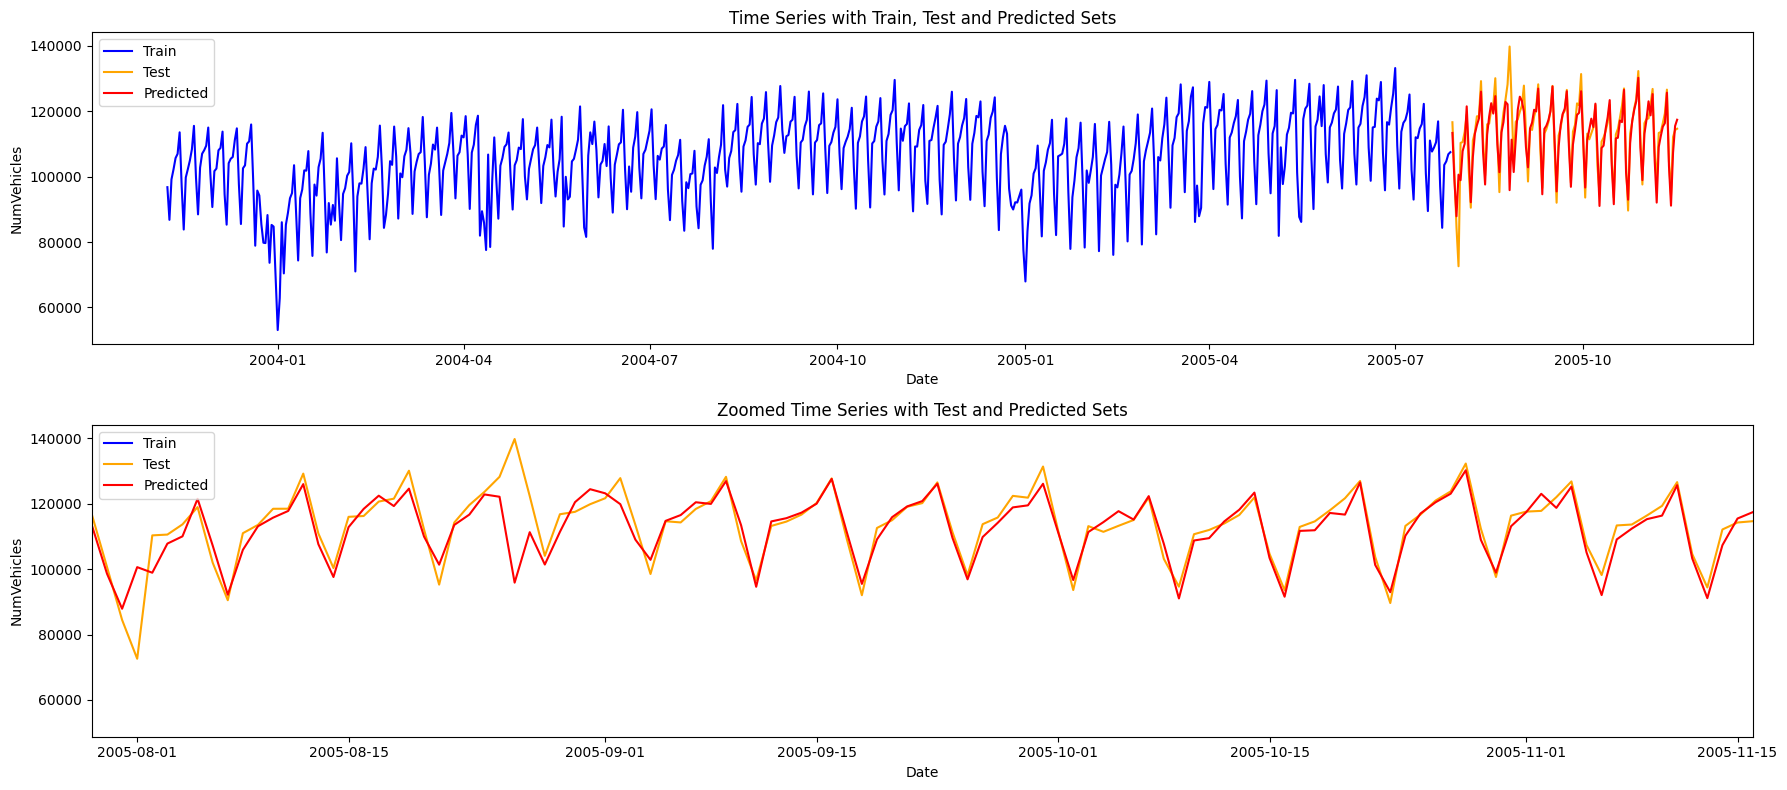

In [85]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# Primeiro plot
axes[0].plot(X_train.index, y_train, label='Train', color='blue')
axes[0].plot(X_test.index, y_test, label='Test', color='orange')
axes[0].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[0].set_title('Time Series with Train, Test and Predicted Sets')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('NumVehicles')

axes[0].legend()

# Segundo plot
axes[1].plot(X_train.index, y_train, label='Train', color='blue')
axes[1].plot(X_test.index, y_test, label='Test', color='orange')
axes[1].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[1].set_xlim([X_test.index.min(), X_test.index.max()])

axes[1].set_title('Zoomed Time Series with Test and Predicted Sets')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NumVehicles')

axes[1].legend()

plt.tight_layout()
plt.show()

In [86]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_metrics(y_test, y_pred)

MAE: 3358.270270270271
RMSE: 6320.510294312329
MAPE: 0.030291645657703


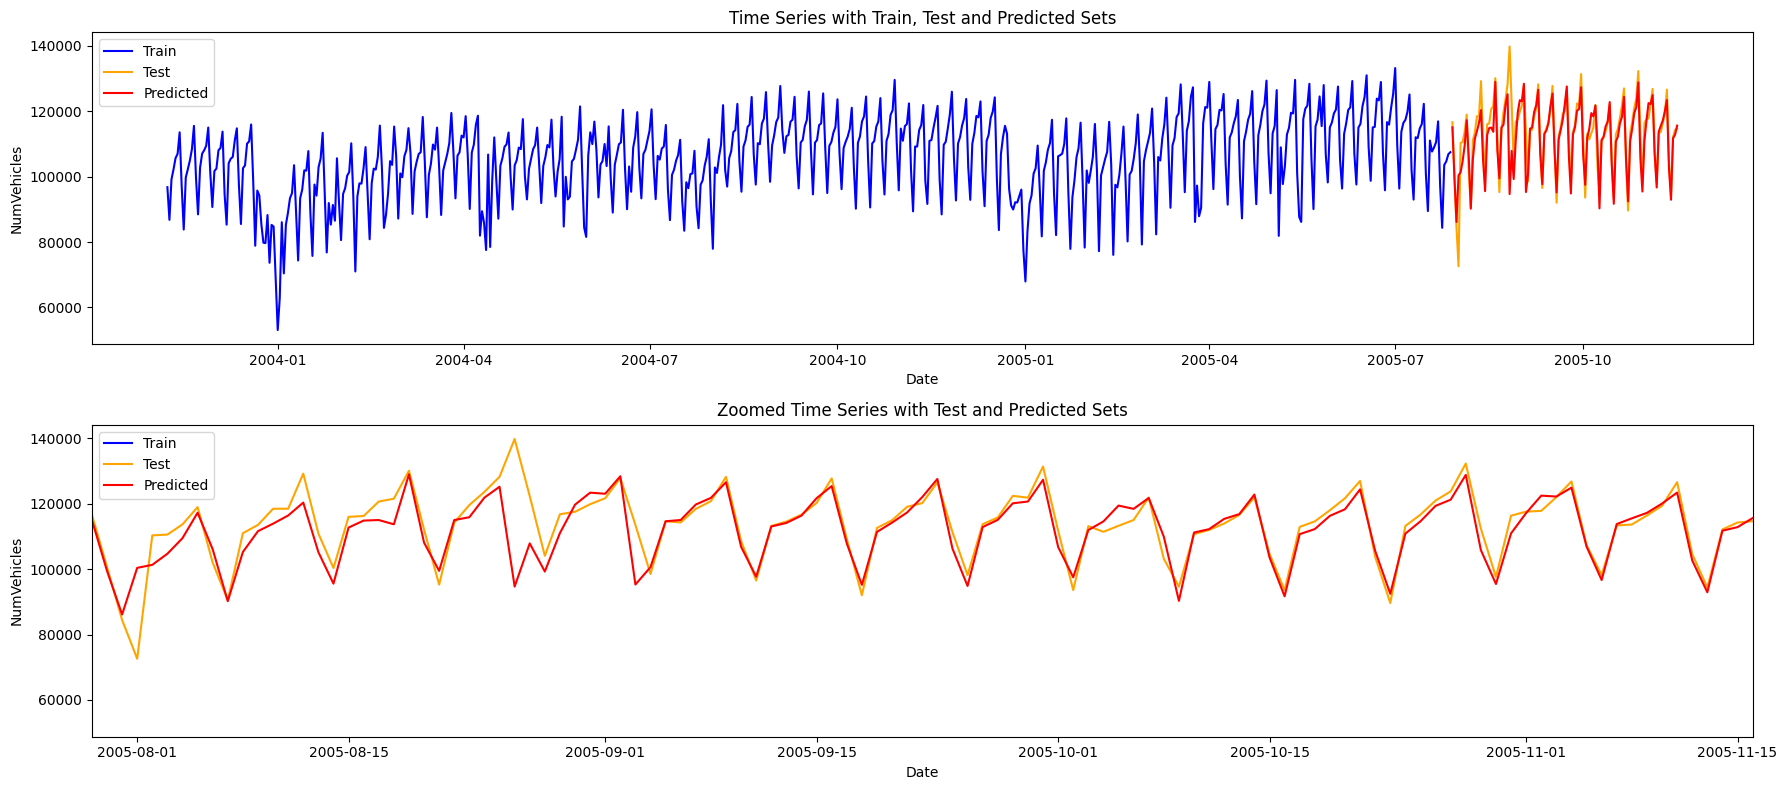

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(18, 8))

# Primeiro plot
axes[0].plot(X_train.index, y_train, label='Train', color='blue')
axes[0].plot(X_test.index, y_test, label='Test', color='orange')
axes[0].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[0].set_title('Time Series with Train, Test and Predicted Sets')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('NumVehicles')

axes[0].legend()

# Segundo plot
axes[1].plot(X_train.index, y_train, label='Train', color='blue')
axes[1].plot(X_test.index, y_test, label='Test', color='orange')
axes[1].plot(X_test.index, y_pred, label='Predicted', color='red')

axes[1].set_xlim([X_test.index.min(), X_test.index.max()])

axes[1].set_title('Zoomed Time Series with Test and Predicted Sets')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('NumVehicles')

axes[1].legend()

plt.tight_layout()
plt.show()

Nessa série temporal, os três modelo tiveram desempenhos excelentes, porém, novamente, a **Regressão Linear** se mostrou a melhor!

### Referências

- [Curso do Kaggle](https://www.kaggle.com/learn/time-series)
- [Decomposição da Série Temporal](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)
- [Features interessantes](https://hackernoon.com/must-know-base-tips-for-feature-engineering-with-time-series-data)